# __Building a Movie Recommender with the MovieLens Dataset__



__Group One Members__
* Esther Francis - Phase Four Group Leader
* Doreen Wanjiru
* Ian Korir
* Gregory Mikuro - Scrum Master

__Team Responsibilities:__ https://github.com/users/gregorymikuro/projects/4 

__Student pace:__ Hybrid

__Instructor name:__ Nikita Njoroge
 

## __1.0 Business Understanding__

## __2.0 Data Understanding__

## __3.0 Data Preparation__ 

### __3.1 Importing necessary Libraries__

In [85]:
# Import Libraries
import os
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from wordcloud import WordCloud
from scipy import sparse 
from surprise import Reader, Dataset
from sklearn.metrics.pairwise import cosine_similarity
from fuzzywuzzy import process
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import csr_matrix
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics. pairwise import cosine_similarity
from surprise.model_selection import cross_validate
from sklearn.decomposition import TruncatedSVD
from surprise.prediction_algorithms import SVD
from surprise.prediction_algorithms import KNNWithMeans, KNNBasic, KNNBaseline
from surprise.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)


### Loading the Datasets

In [86]:
class MovieLensDataExplorer:
    def __init__(self, ratings_path, movies_path, links_path=None, tags_path=None):
        self.ratings = pd.read_csv(ratings_path)
        self.movies = pd.read_csv(movies_path)
        self.links = pd.read_csv(links_path) if links_path else None
        self.tags = pd.read_csv(tags_path) if tags_path else None

    def show_info(self):
        print("## Ratings Data:")
        print(self.ratings.info())
        print("\n## Movies Data:")
        print(self.movies.info())
        if self.links is not None:
            print("\n## Links Data:")
            print(self.links.info())
        if self.tags is not None:
            print("\n## Tags Data:")
            print(self.tags.info())

    def overview(self):
        for df_name, df in zip(['ratings', 'movies', 'links', 'tags'], [self.ratings, self.movies, self.links, self.tags]):
            if df is None:
                continue
            print(f"\n## {df_name.capitalize()} Data Overview:")
            print(df.head().to_markdown(index=False, numalign="left", stralign="left"))  # Show first few rows
            print(f"\nShape: {df.shape}")

            # Unique Values and Missing Values
            unique_counts = df.apply(lambda x: len(set(x.dropna())))
            missing_counts = df.isnull().sum()
            missing_percent = (missing_counts / len(df)) * 100

            summary_df = pd.DataFrame({
                'Unique Values': unique_counts,
                'Missing Values': missing_counts,
                '% Missing': missing_percent
            })
            print(summary_df.to_markdown(numalign="left", stralign="left"))

    def visualize(self):
        # Rating Distribution
        plt.figure(figsize=(8, 5))
        sns.countplot(x='rating', data=self.ratings, hue='rating', dodge=False, palette="viridis")
        plt.legend([],[], frameon=False)
        plt.title("Distribution of Movie Ratings")
        plt.show()

        # Number of Ratings per User and Movie
        plt.figure(figsize=(14, 5))
        plt.subplot(1, 2, 1)
        sns.histplot(self.ratings.groupby('userId')['rating'].count(), bins=30, kde=True)
        plt.title("Number of Ratings per User")
        plt.subplot(1, 2, 2)
        sns.histplot(self.ratings.groupby('movieId')['rating'].count(), bins=30, kde=True)
        plt.title("Number of Ratings per Movie")
        plt.show()

        # Genre Distribution (if movies data is available)
        if self.movies is not None:
            all_genres = [genre for genres in self.movies['genres'].str.split('|') for genre in genres]
            genre_counts = pd.Series(all_genres).value_counts()
        
            plt.figure(figsize=(10, 6))
            
            # Create a custom color palette (optional, but enhances visual clarity)
            palette = sns.color_palette("husl", len(genre_counts))
            
            # Plot the barplot, assigning a specific color to each genre from the palette
            bars = plt.bar(genre_counts.index, genre_counts.values, color=palette)
        
            # Manually create legend handles and labels
            legend_elements = [plt.Rectangle((0, 0), 1, 1, color=palette[i], label=label) 
                               for i, label in enumerate(genre_counts.index)]
        
            plt.xticks(rotation=70)
            plt.xlabel("Genres")
            plt.title("Genre Distribution")
            
            # Place the legend
            plt.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc='upper left')
            
            plt.tight_layout()
            plt.show()




In [87]:
explorer = MovieLensDataExplorer('data/ratings.csv', 'data/movies.csv', 'data/links.csv', 'data/tags.csv')

In [88]:


# Basic Info

explorer.show_info() 


## Ratings Data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB
None

## Movies Data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB
None

## Links Data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   movi

* The MovieLens dataset contains 100,836 ratings from 610 users on 9,742 movies, with additional movie metadata (titles, genres) and links to external databases.

* The dataset also includes 3,683 user-provided tags for movies, though this represents a small fraction of the total movie-rating interactions. 

In [89]:
# overview and summary of stats

explorer.overview()



## Ratings Data Overview:
| userId   | movieId   | rating   | timestamp   |
|:---------|:----------|:---------|:------------|
| 1        | 1         | 4        | 9.64983e+08 |
| 1        | 3         | 4        | 9.64981e+08 |
| 1        | 6         | 4        | 9.64982e+08 |
| 1        | 47        | 5        | 9.64984e+08 |
| 1        | 50        | 5        | 9.64983e+08 |

Shape: (100836, 4)
|           | Unique Values   | Missing Values   | % Missing   |
|:----------|:----------------|:-----------------|:------------|
| userId    | 610             | 0                | 0           |
| movieId   | 9724            | 0                | 0           |
| rating    | 10              | 0                | 0           |
| timestamp | 85043           | 0                | 0           |

## Movies Data Overview:
| movieId   | title                              | genres                                      |
|:----------|:-----------------------------------|:---------------------------------------

* Consistent Movie IDs: The movieId column appears consistently across the ratings, movies, and links datasets, facilitating seamless integration for analysis.
* Sparse Tags Data: The tags dataset is significantly smaller than the ratings dataset, indicating that not all users provide tags for the movies they rate. This suggests that tags might offer a more focused view of specific movie attributes.
* Missing tmdb IDs: There are 8 missing values in the tmdbId column of the links dataset (0.08%).

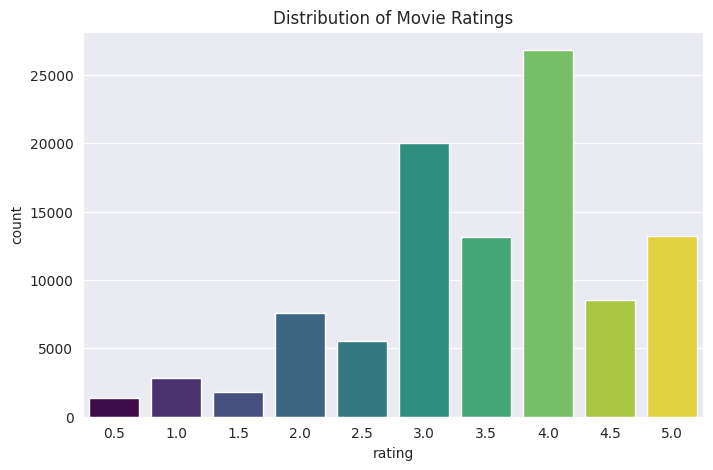

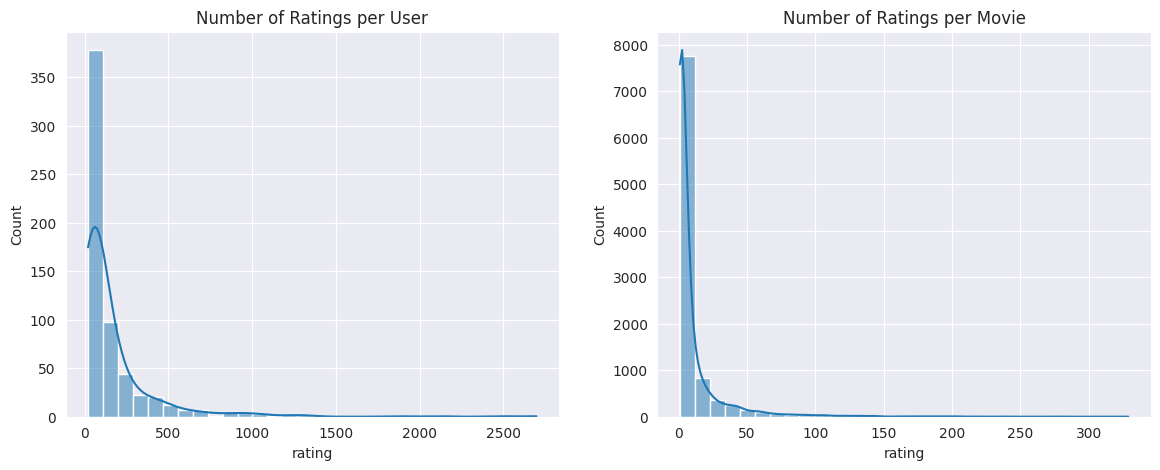

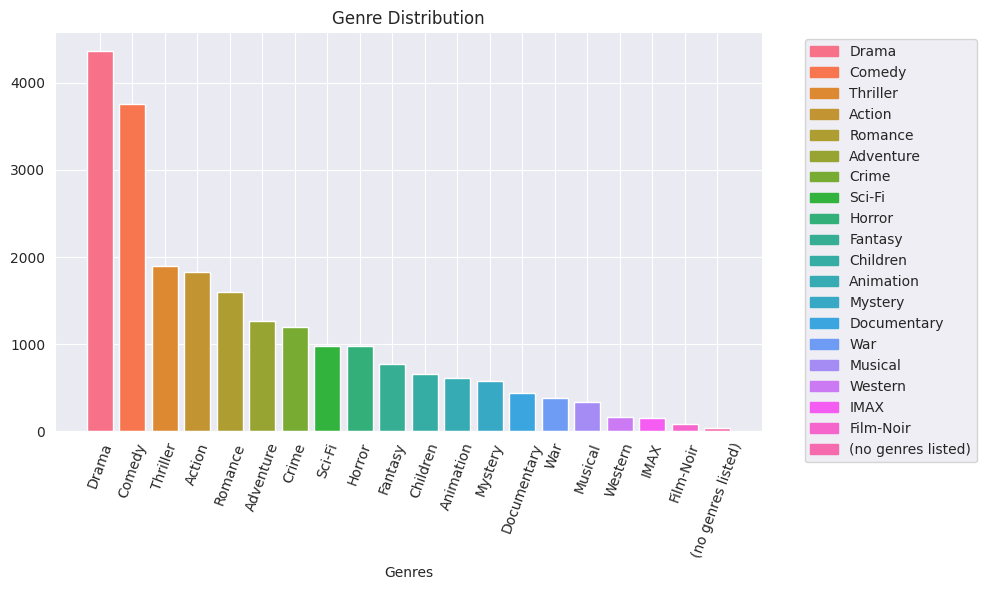

In [90]:
# Overall distributions

explorer.visualize()


* Rating Preferences: The most common ratings are 4 and 3, indicating a general tendency towards positive reviews, but also a significant portion of average ratings.
* Power Users and Popular Movies: A few users have rated a large number of movies (the long tail in the 'Number of Ratings per User' distribution), and a few movies have received a large number of ratings (the long tail in 'Number of Ratings per Movie' distribution). These outliers could significantly influence collaborative filtering recommendations.
* Genre Diversity: The dataset covers a wide range of genres, but some are more prevalent than others (e.g., Drama, Comedy, Thriller). This suggests that the recommender system might need to handle genre imbalances or incorporate content-based filtering to recommend movies from less popular genres.

## __4.0 Data Cleaning__ 

In this analysis, we'll prioritize the core user-item interactions captured in the `ratings` and `movies` datasets.  The `links` dataset, providing links to external databases (IMDb and TMDb), is not directly relevant to our collaborative filtering approach and will be excluded.  While the `tags` dataset offers potentially valuable insights into movie content, its inherent sparsity (only 3683 tags compared to 100,836 ratings) and potential user bias pose challenges for its inclusion in this initial analysis.

Our data cleaning strategy aims to refine the dataset for subsequent analysis and modeling:

1.  **Merge `ratings` and `movies`:** We'll merge the `ratings` and `movies` DataFrames on the `movieId` column. This consolidation is essential for associating user ratings with specific movie titles and genres, enabling us to examine user preferences in relation to movie attributes and facilitating various recommendation strategies.

2.  **Timestamp Removal:** The `timestamp` column, while potentially useful for temporal analysis, is not immediately relevant.  Therefore, we'll drop this column to reduce the dataset's dimensionality and computational burden.

3.  **Duplicate Elimination:** We'll rigorously identify and remove duplicate entries within the merged DataFrame, ensuring each user-movie rating pair is unique. This step is crucial to prevent biases in subsequent analyses and models arising from duplicate ratings.

4.  **Genre Transformation:** The `genres` column in the `movies` DataFrame contains multiple genres per movie separated by '|'. We'll split this column into a list of individual genres to enable genre-based analysis and filtering, as well as potential integration into content-based filtering strategies if desired later.

5. **Title-Year Separation:** We will also extract the release year from the movie title and store it as a separate column for further analysis.
 
6. **Bayesian Average Calculation:** We'll compute the Bayesian Average for each movie's rating.  This approach mitigates the inherent bias of simple average ratings, especially for movies with few ratings, by incorporating the global average rating and the average number of votes per movie. The Bayesian Average formula is:

```
Bayesian Average = ( (C * m) + (R * v) ) / (C + v)
```

where:

*   R = average rating for the movie
*   v = number of votes for the movie
*   m = average rating across all movies
*   C = average number of votes per movie across all movies

By comparing the Bayesian Average with simple average ratings, we'll assess the impact of this adjustment on the perceived popularity of movies, particularly those with limited ratings. We'll visually represent this comparison to discern how the Bayesian Average smooths out the rating distribution.


In [91]:
class MovieLensDataCleaner:
    def __init__(self, ratings_path, movies_path, min_reviews):
        self.ratings = pd.read_csv(ratings_path)
        self.movies = pd.read_csv(movies_path)
        self.min_reviews = min_reviews
        self.cleaned_df = None
        self.result_df = None

    def clean_and_merge(self):
        # Merge DataFrames
        df = pd.merge(self.ratings, self.movies, on='movieId')

        # Drop Timestamp
        df.drop('timestamp', axis=1, inplace=True)

        # Drop Duplicates
        df.drop_duplicates(inplace=True)

        # Genre Cleaning
        df['genres'] = df['genres'].str.split('|')

        # Extract Title and Year
        df['year'] = df['title'].str.extract(r'\((\d{4})\)', expand=False)
        df['year'] = pd.to_numeric(df['year'], errors='coerce')

        # Impute missing year values with median before dropping NaNs
        median_year = df['year'].median()
        df['year'] = df['year'].fillna(median_year).astype(int)

        df['title'] = df['title'].str.replace(r'\(\d{4}\)', '', regex=True).str.strip()

        # Drop NaN values for all columns (including year) after imputation
        self.cleaned_df = df.dropna()

        return self.cleaned_df

    def calculate_bayesian_average(self):
        if self.cleaned_df is None:
            raise ValueError("Data not cleaned. Call 'clean_and_merge' before calculating Bayesian average.")
        
        # Calculate mean rating and number of ratings for each movie
        movie_stats = self.cleaned_df.groupby('movieId').agg({'rating': ['mean', 'count']})
        movie_stats.columns = ['mean', 'count']
        
        # Calculate the global mean rating
        global_mean = self.cleaned_df['rating'].mean()
        
        # Calculate the Bayesian average
        def bayesian_avg(row):
            m = self.min_reviews
            v = row['count']
            r = row['mean']
            return (v / (v + m)) * r + (m / (v + m)) * global_mean
        
        movie_stats['bayesian_avg'] = movie_stats.apply(bayesian_avg, axis=1)
        
        # Join the Bayesian average with the cleaned dataframe
        self.result_df = self.cleaned_df.join(movie_stats['bayesian_avg'], on='movieId')
        self.result_df = self.result_df.rename(columns={"bayesian_avg": "avg_rating"})
        
        # Drop unnecessary columns
        self.result_df = self.result_df.drop(columns=['mean', 'count'], errors='ignore')
        
        return self.result_df

    def save_cleaned_data(self):
        if self.result_df is None:
            raise ValueError("Data not processed. Call 'calculate_bayesian_average' before saving cleaned data.")
    
        # Drop the 'rating' column
        result_df = self.result_df.drop(columns=['rating'], errors='ignore')
    
        # Save the cleaned data to CSV in the data folder, overwriting if exists
        output_path = os.path.join('data', 'cleaned-data.csv')
        os.makedirs(os.path.dirname(output_path), exist_ok=True)  # Create directory if it doesn't exist
        result_df.to_csv(output_path, index=False, mode='w')  # Use mode='w' to overwrite
        print(f"Cleaned data saved to: {output_path}")

In [92]:
cleaner = MovieLensDataCleaner('data/ratings.csv', 'data/movies.csv', min_reviews=50)

In [93]:
cleaned_df = cleaner.clean_and_merge()


In [94]:

df_with_bayesian_avg = cleaner.calculate_bayesian_average()
df_with_bayesian_avg.info()
df_with_bayesian_avg


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 7 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   userId      100836 non-null  int64  
 1   movieId     100836 non-null  int64  
 2   rating      100836 non-null  float64
 3   title       100836 non-null  object 
 4   genres      100836 non-null  object 
 5   year        100836 non-null  int64  
 6   avg_rating  100836 non-null  float64
dtypes: float64(2), int64(3), object(2)
memory usage: 5.4+ MB


,userId,movieId,rating,title,genres,year,avg_rating
0,1,1,4.0,Toy Story,"[Adventure, Animation, Children, Comedy, Fantasy]",1995,3.841803
1,1,3,4.0,Grumpier Old Men,"[Comedy, Romance]",1995,3.378214
2,1,6,4.0,Heat,"[Action, Crime, Thriller]",1995,3.799854
3,1,47,5.0,Seven (a.k.a. Se7en),"[Mystery, Thriller]",1995,3.881731
4,1,50,5.0,"Usual Suspects, The","[Crime, Mystery, Thriller]",1995,4.092826
...,...,...,...,...,...,...,...
100831,610,166534,4.0,Split,"[Drama, Horror, Thriller]",2017,3.483533
100832,610,168248,5.0,John Wick: Chapter Two,"[Action, Crime, Thriller]",2017,3.580313
100833,610,168250,5.0,Get Out,[Horror],2017,3.531967
100834,610,168252,5.0,Logan,"[Action, Sci-Fi]",2017,3.761038


The Bayesian Average rating significantly adjusts the perceived ranking of movies with few ratings, potentially elevating lesser-known films in the recommendations. Movies with many ratings experience minimal adjustments, as their average rating is already a reliable indicator of popularity. No duplicate ratings were found in the dataset, ensuring the integrity of subsequent analyses.

In [95]:
cleaner.save_cleaned_data()

Cleaned data saved to: data/cleaned-data.csv


## __5.0 Exploratory Data Analysis__

### __5.1 Univariate Analysis__

In [96]:
class MovieLensUnivariateEDA:
    def __init__(self, data_path='data/cleaned-data.csv'):
        self.df = pd.read_csv(data_path)

    def analyze_ratings(self):
        print("### Rating Distribution Analysis:")

        # Histogram of avg_rating
        plt.figure(figsize=(8, 6))
        sns.histplot(self.df['avg_rating'], bins=10, kde=True, color='skyblue')
        plt.title('Distribution of Average Movie Ratings')
        plt.xlabel('Average Rating')
        plt.ylabel('Frequency')
        plt.show()

    def analyze_genres(self):
        print("\n### Genre Analysis:")

        # Flatten and Count Genres
        all_genres = [genre for genres in self.df['genres'].apply(eval) for genre in genres]
        genre_counts = pd.Series(all_genres).value_counts()

        # Bar plot of Top 10 and Least 10 Genres
        fig, axes = plt.subplots(1, 2, figsize=(20, 6))
        sns.barplot(x=genre_counts[:10].index, y=genre_counts[:10].values, ax=axes[0], hue=genre_counts[:10].index, dodge=False, palette='viridis')
        axes[0].legend([],[], frameon=False)  # Remove legend
        axes[0].set_title('Top 10 Movie Genres by Frequency')
        axes[0].set_xlabel('Genre')
        axes[0].set_ylabel('Count')
        axes[0].tick_params(axis='x', rotation=45)
        sns.barplot(x=genre_counts[-10:].index, y=genre_counts[-10:].values, ax=axes[1], hue=genre_counts[-10:].index, dodge=False, palette='viridis')
        axes[1].legend([],[], frameon=False)  # Remove legend
        axes[1].set_title('Least 10 Movie Genres by Frequency')
        axes[1].set_xlabel('Genre')
        axes[1].set_ylabel('Count')
        axes[1].tick_params(axis='x', rotation=45)
        plt.show()

        # Word cloud of Genres (Larger and more readable)
        wordcloud = WordCloud(width=1200, height=600, background_color='white', min_font_size=10).generate_from_frequencies(genre_counts)
        plt.figure(figsize=(15, 8))
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.axis("off")
        plt.title('Word Cloud of Movie Genres')
        plt.show()

    def analyze_popularity(self):
        print("\n### Movie Popularity Analysis:")

        # Calculate rating counts per movie
        movie_rating_counts = self.df['movieId'].value_counts()

        # Simple scatterplot (without genre hue)
        plt.figure(figsize=(10, 6))
        sns.scatterplot(x=movie_rating_counts, y=self.df.groupby('movieId')['avg_rating'].mean(), color='skyblue', alpha=0.5)
        plt.title('Average Rating vs. Number of Ratings per Movie')
        plt.xlabel('Number of Ratings')
        plt.ylabel('Average Rating')
        plt.show()

    def analyze_years(self):
        print("\n### Year Analysis:")

        # Calculate 4-year ranges
        min_year = int(self.df['year'].min())
        max_year = int(self.df['year'].max())
        bins = range(min_year, max_year + 5, 4)  # Create bins in 4-year intervals

        # Create year_range column
        self.df['year_range'] = pd.cut(self.df['year'], bins=bins, labels=False) * 4 + min_year

        # Bar chart of Number of Movies per Year Range
        year_range_counts = self.df['year_range'].value_counts().sort_index()
        plt.figure(figsize=(12, 6))
        sns.barplot(x=year_range_counts.index, y=year_range_counts.values, color='skyblue')
        plt.title('Number of Movies per 4-Year Range')
        plt.xlabel('Year Range')
        plt.ylabel('Number of Movies')
        plt.xticks(rotation=45)
        plt.show()

    def analyze_top_bottom(self, top_n=5):
        print("\n### Top and Bottom Rated Movies & Users:")
        
        # Top and Bottom Movies by Average Rating
        top_movies = self.df.groupby('title')['avg_rating'].mean().nlargest(top_n)
        bottom_movies = self.df.groupby('title')['avg_rating'].mean().nsmallest(top_n)
    
        print("\nTop Rated Movies:")
        print(top_movies.to_markdown(numalign='left', stralign='left'))
        print("\nBottom Rated Movies:")
        print(bottom_movies.to_markdown(numalign='left', stralign='left'))
    
        # Top and Bottom Users by Average Rating
        top_users = self.df.groupby('userId')['avg_rating'].mean().nlargest(top_n)
        bottom_users = self.df.groupby('userId')['avg_rating'].mean().nsmallest(top_n)
    
        print("\nTop Raters (By Average Rating):")
        print(top_users.to_markdown(numalign='left', stralign='left'))
        print("\nBottom Raters (By Average Rating):")
        print(bottom_users.to_markdown(numalign='left', stralign='left'))
    
        # Top and Bottom Users by Number of Ratings (Bar Plots)
        user_rating_counts = self.df.groupby('userId')['avg_rating'].count()
        top_raters_by_count = user_rating_counts.nlargest(top_n)
        bottom_raters_by_count = user_rating_counts.nsmallest(top_n)
    
        print("\nTop Raters (By Number of Ratings):")
        print(top_raters_by_count.to_markdown(numalign='left', stralign='left'))
        print("\nBottom Raters (By Number of Ratings):")
        print(bottom_raters_by_count.to_markdown(numalign='left', stralign='left'))
    
        

In [97]:
# df_check = pd.read_csv('data/cleaned-data.csv')
# df_check.info()

In [98]:
eda = MovieLensUnivariateEDA()  


### Rating Distribution Analysis:


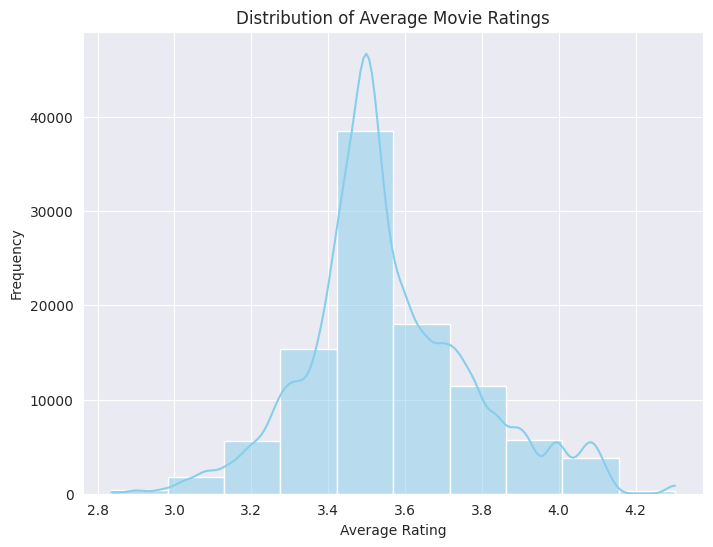

In [99]:
eda.analyze_ratings()


### Genre Analysis:


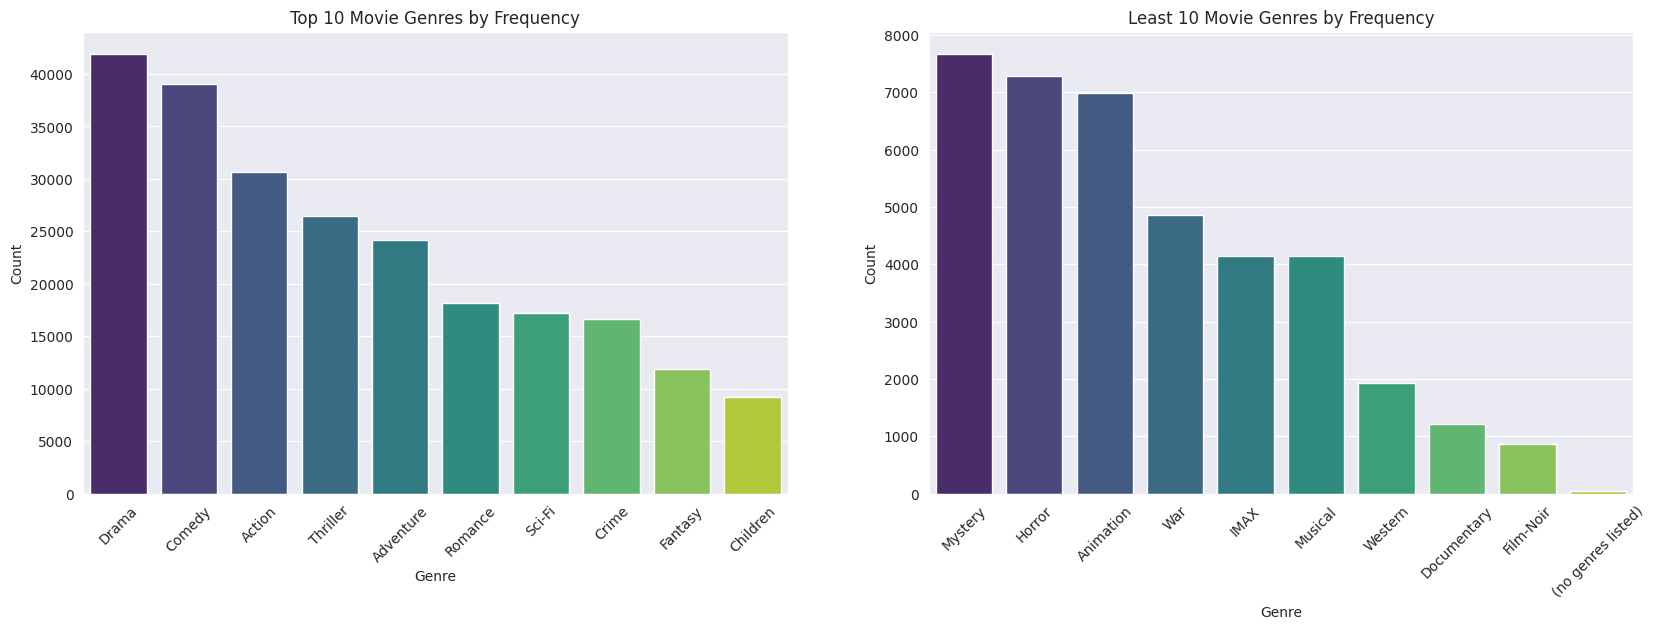

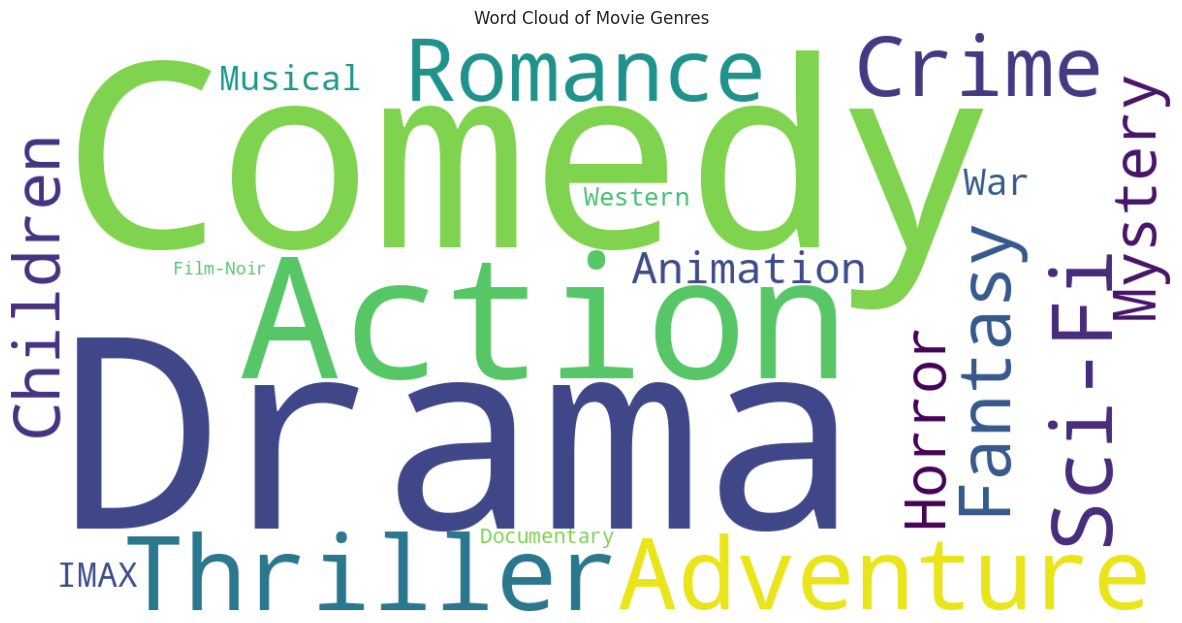

In [100]:
eda.analyze_genres()


### Movie Popularity Analysis:


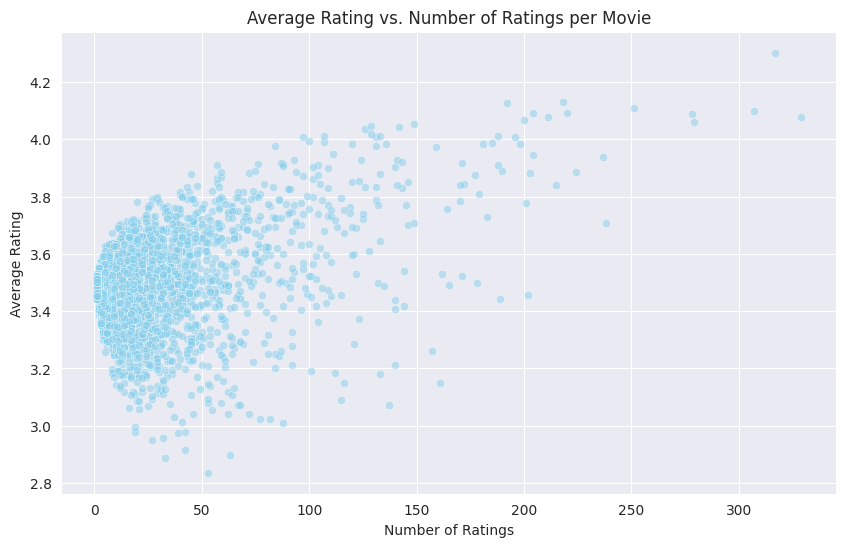

In [101]:
eda.analyze_popularity()


### Year Analysis:


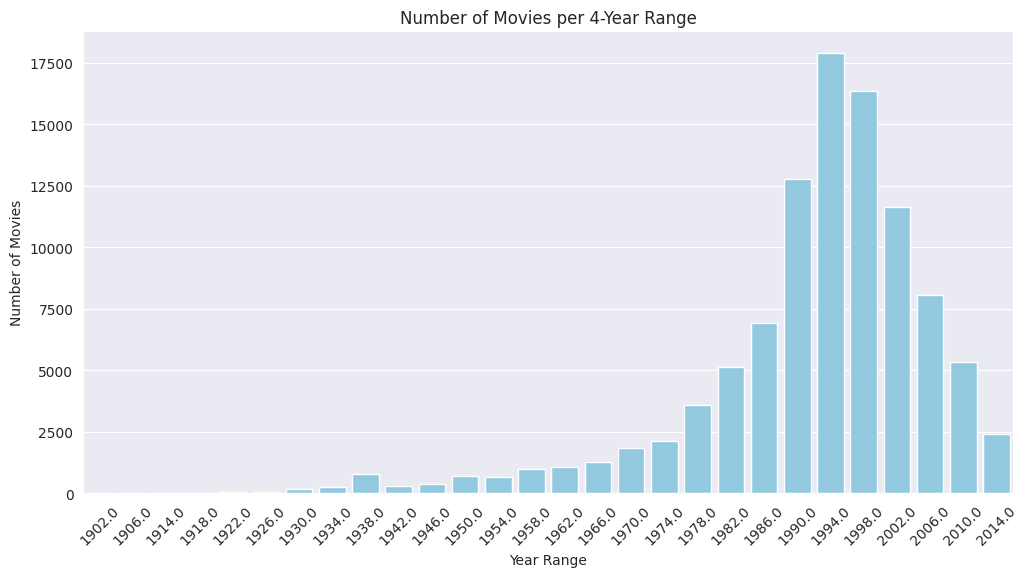

In [102]:
eda.analyze_years()

In [103]:
eda.analyze_top_bottom()


### Top and Bottom Rated Movies & Users:

Top Rated Movies:
| title                              | avg_rating   |
|:-----------------------------------|:-------------|
| Shawshank Redemption, The          | 4.30266      |
| Fight Club                         | 4.12902      |
| Godfather, The                     | 4.12635      |
| Star Wars: Episode IV - A New Hope | 4.10989      |
| Pulp Fiction                       | 4.09966      |

Bottom Rated Movies:
| title                           | avg_rating   |
|:--------------------------------|:-------------|
| Wild Wild West                  | 2.83571      |
| Coneheads                       | 2.89892      |
| Batman & Robin                  | 2.91389      |
| Anaconda                        | 2.94906      |
| I Know What You Did Last Summer | 2.95827      |

Top Raters (By Average Rating):
| userId   | avg_rating   |
|:---------|:-------------|
| 549      | 3.94902      |
| 189      | 3.94202      |
| 251      | 3.93876      |
| 231    

### __5.2 Bivariate Analysis__


### Year vs. Average Rating Analysis:


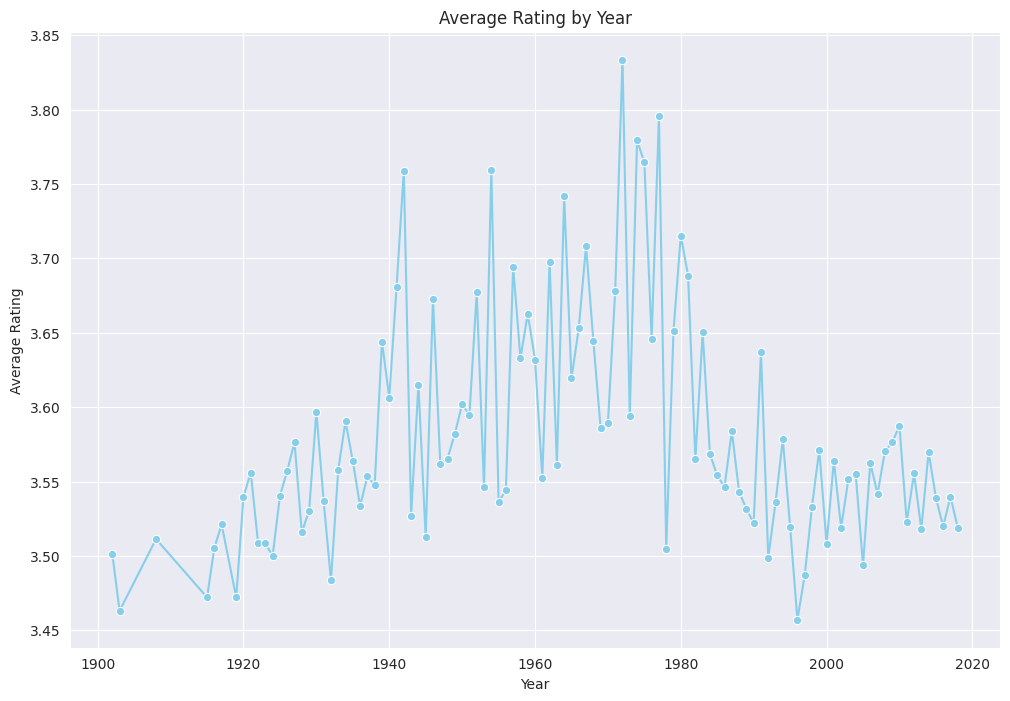


### Genres vs. Average Rating Analysis:


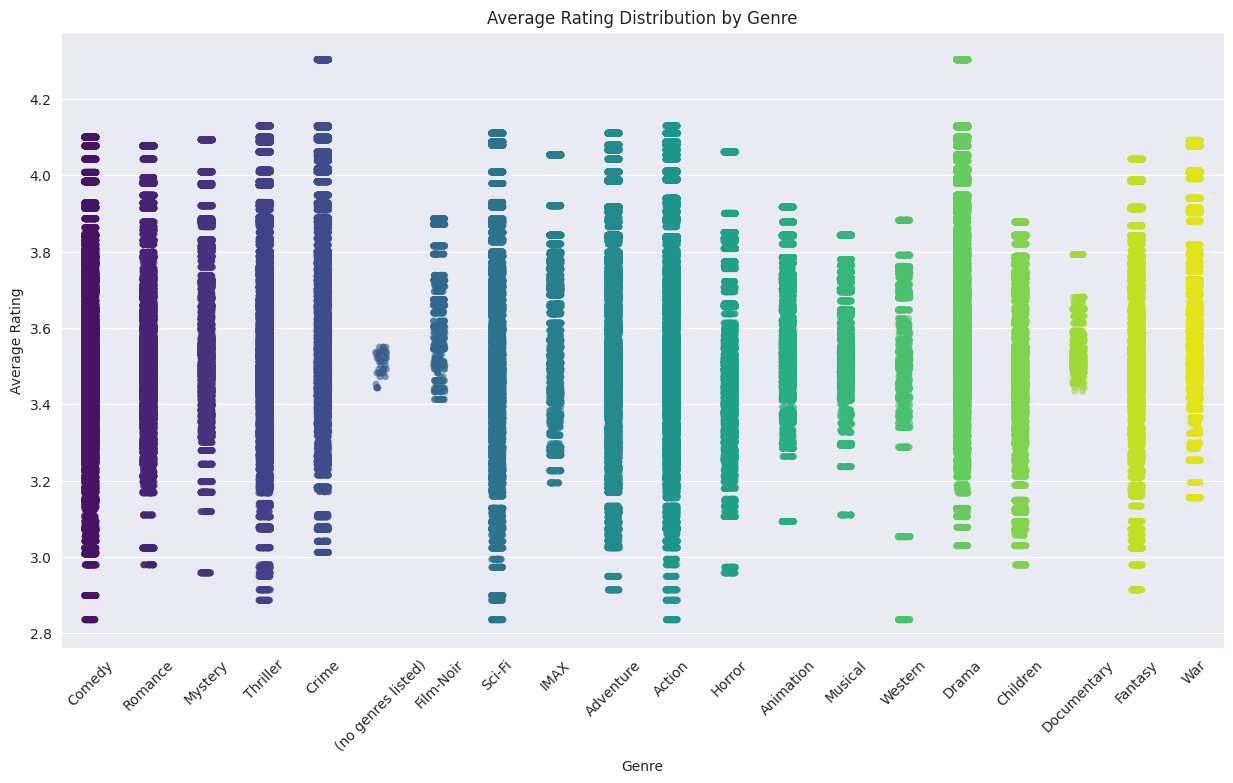

In [104]:
class MovieLensBivariateEDA:
    def __init__(self, data_path='data/cleaned-data.csv'):
        self.df = pd.read_csv(data_path)
        self.df['genres'] = self.df['genres'].apply(eval)  # Ensure genres are lists
        self._prepare_genre_columns()

    def _prepare_genre_columns(self):
        # Get a set of all unique genres
        unique_genres = set(g for genres in self.df['genres'] for g in genres)
        
        # Create a column for each genre
        for genre in unique_genres:
            self.df[genre] = self.df['genres'].apply(lambda x: 1 if genre in x else 0)

    def analyze_year_vs_avg_rating(self):
        print("\n### Year vs. Average Rating Analysis:")

        # Calculate average rating for each year
        year_avg_ratings = self.df.groupby('year')['avg_rating'].mean()

        # Plotting
        plt.figure(figsize=(12, 8))
        sns.lineplot(x=year_avg_ratings.index, y=year_avg_ratings.values, marker='o', color='skyblue')
        plt.title('Average Rating by Year')
        plt.xlabel('Year')
        plt.ylabel('Average Rating')
        plt.show()

    def analyze_genres_vs_avg_rating(self):
        print("\n### Genres vs. Average Rating Analysis:")

        # Create a long-form DataFrame for Seaborn
        genre_ratings = []
        for genre in self.df.columns:
            if genre not in ['userId', 'movieId', 'title', 'genres', 'year', 'avg_rating']:
                genre_data = self.df[self.df[genre] == 1]
                for rating in genre_data['avg_rating']:
                    genre_ratings.append((genre, rating))
        
        genre_ratings_df = pd.DataFrame(genre_ratings, columns=['Genre', 'Average Rating'])

        # Plotting
        plt.figure(figsize=(15, 8))
        sns.stripplot(x='Genre', y='Average Rating', data=genre_ratings_df, jitter=True, hue='Genre', palette='viridis', alpha=0.6, legend=False)
        plt.title('Average Rating Distribution by Genre')
        plt.xlabel('Genre')
        plt.ylabel('Average Rating')
        plt.xticks(rotation=45)
        plt.show()

# Example usage
eda = MovieLensBivariateEDA('data/cleaned-data.csv')
eda.analyze_year_vs_avg_rating()
eda.analyze_genres_vs_avg_rating()


### __5.3 Multivariate Analysis__ 

In [105]:
class MultivariateAnalysis:
    def __init__(self, data_path, n_components=20):
        """
        Initializes the MultivariateAnalysis class.

        Parameters:
        - data_path: Path to the CSV file containing the data.
        - n_components: Number of latent features for dimensionality reduction.
        """
        self.data = pd.read_csv(data_path)
        self.n_components = n_components
        self.model = None
        self.trainset = None
        self.movie_titles = {}
        self.movie_mapper = {}
        self.movie_inv_mapper = {}
        self._prepare_data()

    def _prepare_data(self):
        """
        Prepares the data for SVD model.
        """
        # Create a mapping of movieId to title and index
        movie_ids = self.data['movieId'].unique()
        self.movie_titles = self.data.drop_duplicates('movieId')[['movieId', 'title']].set_index('movieId')['title'].to_dict()
        self.movie_mapper = {movie_id: i for i, movie_id in enumerate(movie_ids)}
        self.movie_inv_mapper = {i: movie_id for i, movie_id in enumerate(movie_ids)}

        # Prepare data for surprise
        reader = Reader(rating_scale=(0.5, 5.0))
        data = Dataset.load_from_df(self.data[['userId', 'movieId', 'avg_rating']], reader)
        trainset = data.build_full_trainset()

        # Initialize and train the SVD model
        self.model = SVD(n_factors=self.n_components)
        self.model.fit(trainset)
        self.trainset = trainset

    def find_similar_movies(self, movie_id, top_k=5):
        """
        Finds similar movies to a given movie.

        Parameters:
        - movie_id: The ID of the movie to find similar movies for.
        - top_k: The number of similar movies to return.

        Returns:
        - A list of movie titles that are similar to the given movie.
        """
        if movie_id not in self.movie_mapper:
            raise ValueError("Movie ID not found in the dataset.")
        
        movie_index = self.movie_mapper[movie_id]
        movie_vector = np.array(self.model.qi[movie_index]).reshape(1, -1)
        all_movie_vectors = np.array(self.model.qi)
        similarities = cosine_similarity(movie_vector, all_movie_vectors)
        similar_indices = similarities.argsort()[0][-top_k-1:-1][::-1]  # Exclude the movie itself and sort

        similar_movies = [self.movie_titles[self.movie_inv_mapper[idx]] for idx in similar_indices]
        return similar_movies


if __name__ == "__main__":
    data_path = 'data/cleaned-data.csv'
    analysis = MultivariateAnalysis(data_path, n_components=20)
    
    movie_id = 3  # Example movieId
    similar_movies = analysis.find_similar_movies(movie_id)
    
    print(f"Movies similar to {analysis.movie_titles[movie_id]}:")
    for movie in similar_movies:
        print(movie)


Movies similar to Grumpier Old Men:
High Art
City by the Sea
Blood of Heroes, The (Salute of the Jugger, The)
Santa Claus Is a Stinker (Le Père Noël est une ordure)
Camille


## __6.0 Modeling and Evaluation__

### __6.1 Data Pre-Processing__

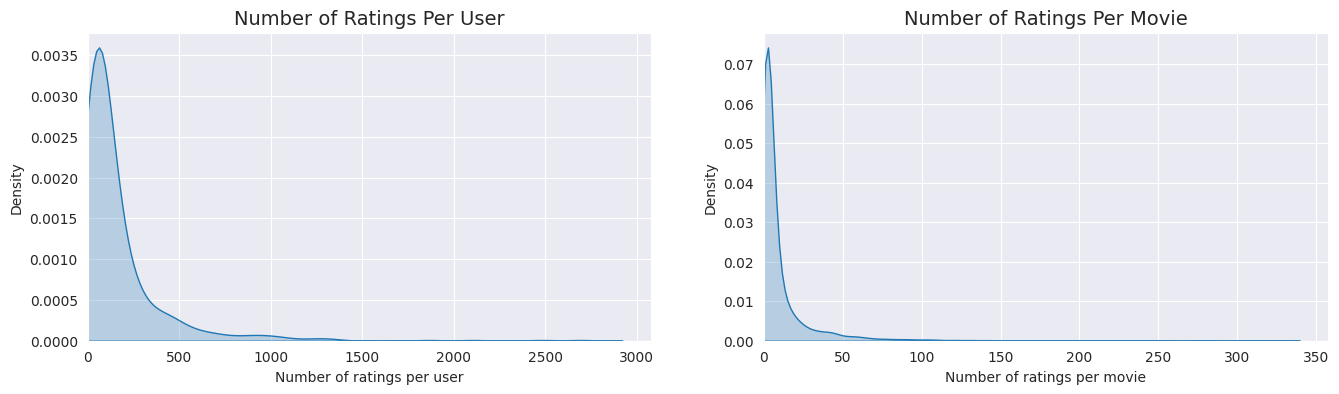

In [106]:
class DataPreprocessing:
    def __init__(self, filepath):
        self.filepath = filepath
        self.data = pd.read_csv(filepath)
        
    def preprocess(self):
        # Convert genres from string representation to list
        self.data['genres'] = self.data['genres'].apply(eval)
        
        # Create user-item matrix
        self.X, self.user_mapper, self.movie_mapper, self.user_inv_mapper, self.movie_inv_mapper = self.create_user_item_matrix()
        
        # Create genre matrix
        self.genre_matrix = self.create_genre_matrix()
        
        return self.X, self.genre_matrix, self.user_mapper, self.movie_mapper, self.user_inv_mapper, self.movie_inv_mapper
    
    def create_user_item_matrix(self):
        M = self.data['userId'].nunique()
        N = self.data['movieId'].nunique()

        user_mapper = dict(zip(np.unique(self.data["userId"]), list(range(M))))
        movie_mapper = dict(zip(np.unique(self.data["movieId"]), list(range(N))))
        
        user_inv_mapper = dict(zip(list(range(M)), np.unique(self.data["userId"])))
        movie_inv_mapper = dict(zip(list(range(N)), np.unique(self.data["movieId"])))
        
        user_index = [user_mapper[i] for i in self.data['userId']]
        item_index = [movie_mapper[i] for i in self.data['movieId']]

        X = csr_matrix((self.data["avg_rating"], (user_index, item_index)), shape=(M, N))
        
        return X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper
    
    def create_genre_matrix(self):
        mlb = MultiLabelBinarizer()
        genre_matrix = mlb.fit_transform(self.data['genres'])
        return genre_matrix
    
    
# Define the Visualization class
class Visualization:
    @staticmethod
    def plot_ratings_distribution(n_ratings_per_user, n_ratings_per_movie):
        plt.figure(figsize=(16, 4))
        plt.subplot(1, 2, 1)
        sns.kdeplot(n_ratings_per_user, shade=True)
        plt.xlim(0)
        plt.title("Number of Ratings Per User", fontsize=14)
        plt.xlabel("Number of ratings per user")
        plt.ylabel("Density")

        plt.subplot(1, 2, 2)
        sns.kdeplot(n_ratings_per_movie, shade=True)
        plt.xlim(0)
        plt.title("Number of Ratings Per Movie", fontsize=14)
        plt.xlabel("Number of ratings per movie")
        plt.ylabel("Density")
        plt.show()

# Load and preprocess data
data_preprocessing = DataPreprocessing('data/cleaned-data.csv')
X, genre_matrix, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper = data_preprocessing.preprocess()


n_ratings_per_user = data_preprocessing.data.groupby('userId').size()
n_ratings_per_movie = data_preprocessing.data.groupby('movieId').size()
Visualization.plot_ratings_distribution(n_ratings_per_user, n_ratings_per_movie)

### 6.1 __Modeling__

### 6.1.1 Collaborative Filtering - Baseline Model

In [107]:
class CollaborativeFiltering:
    def __init__(self, X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper):
        self.X = X
        self.user_mapper = user_mapper
        self.movie_mapper = movie_mapper
        self.user_inv_mapper = user_inv_mapper
        self.movie_inv_mapper = movie_inv_mapper
    
    def find_similar_movies(self, movie_id, k=5, metric='cosine'):
        """
        Finds similar movies to a given movie using collaborative filtering.

        Parameters:
        - movie_id: The ID of the movie to find similar movies for.
        - k: The number of similar movies to return.
        - metric: The distance metric to use ('cosine' or 'euclidean').

        Returns:
        - A list of movie titles that are similar to the given movie.
        """
        X = self.X.T
        movie_ids = []

        if movie_id not in self.movie_mapper:
            raise ValueError("Movie ID not found in the dataset.")
        
        movie_ind = self.movie_mapper[movie_id]
        movie_vec = X[movie_ind].reshape(1, -1)
        
        # Initialize NearestNeighbors
        kNN = NearestNeighbors(n_neighbors=k+1, algorithm="brute", metric=metric)
        kNN.fit(X)
        
        # Find neighbors
        distances, indices = kNN.kneighbors(movie_vec, return_distance=True)
        
        # Exclude the movie itself
        similar_indices = indices[0][1:]
        
        # Retrieve movie IDs and titles
        movie_ids = [self.movie_inv_mapper[idx] for idx in similar_indices]
        movie_titles = [self.movie_mapper[movie_id] for movie_id in movie_ids]
        
        return movie_titles


# Collaborative filtering model
cf_model = CollaborativeFiltering(X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper)
similar_movies_cf = cf_model.find_similar_movies(movie_id=1, k=5)

print(f"Collaborative Filtering Recommendations for Movie ID 1:")
for title in similar_movies_cf:
    print(title)


Collaborative Filtering Recommendations for Movie ID 1:
615
418
314
224
546


### 6.1.2 Hybrid Approach 

In [109]:
import pickle
import os
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from fuzzywuzzy import process

class HybridRecommender:
    def __init__(self, X, genre_matrix, user_mapper, movie_mapper, movie_titles):
        self.X = X
        self.genre_matrix = genre_matrix
        self.user_mapper = user_mapper
        self.movie_mapper = movie_mapper
        self.movie_titles = movie_titles

    def movie_finder(self, title):
        all_titles = self.movie_titles['title'].tolist()
        closest_match = process.extractOne(title, all_titles)
        return closest_match[0]
    
    def get_content_based_recommendations(self, title_string, n_recommendations=10):
        title = self.movie_finder(title_string)
        idx = self.movie_titles[self.movie_titles['title'] == title].index[0]
        sim_scores = cosine_similarity(self.genre_matrix[idx].reshape(1, -1), self.genre_matrix).flatten()
        sim_scores = list(enumerate(sim_scores))
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
        
        recommendations = []
        seen_titles = set()
        
        for i, score in sim_scores:
            movie_title = self.movie_titles.iloc[i]['title']
            if movie_title not in seen_titles and movie_title != title:
                recommendations.append(movie_title)
                seen_titles.add(movie_title)
                if len(recommendations) >= n_recommendations:
                    break
        
        return recommendations

    def save_model(self, filename):
        # Ensure the 'models' directory exists
        os.makedirs(os.path.dirname(filename), exist_ok=True)
        
        # Save the model to a .pkl file
        with open(filename, 'wb') as file:
            pickle.dump({
                'X': self.X,
                'genre_matrix': self.genre_matrix,
                'user_mapper': self.user_mapper,
                'movie_mapper': self.movie_mapper,
                'movie_titles': self.movie_titles
            }, file)

    @staticmethod
    def load_model(filename):
        with open(filename, 'rb') as file:
            data = pickle.load(file)
            return HybridRecommender(
                X=data['X'],
                genre_matrix=data['genre_matrix'],
                user_mapper=data['user_mapper'],
                movie_mapper=data['movie_mapper'],
                movie_titles=data['movie_titles']
            )


# Assuming you have initialized the HybridRecommender object
movie_titles = data_preprocessing.data[['movieId', 'title']]
hybrid_model = HybridRecommender(X, genre_matrix, user_mapper, movie_mapper, movie_titles)

# Save the model
hybrid_model.save_model('models/hybrid_recommender.pkl')

# Load the model
loaded_model = HybridRecommender.load_model('models/hybrid_recommender.pkl')


## __7.0 Deployment__

## __8.0 Conclusion, Recommendations and Next Steps__